# Content:
1. Neural Machine Translation (NMT) with Attention
2. Transformers
3. ELMo, GPT, BERT, T5
4. Hugging Face

# Neural Machine Translation (NMT) with Attention

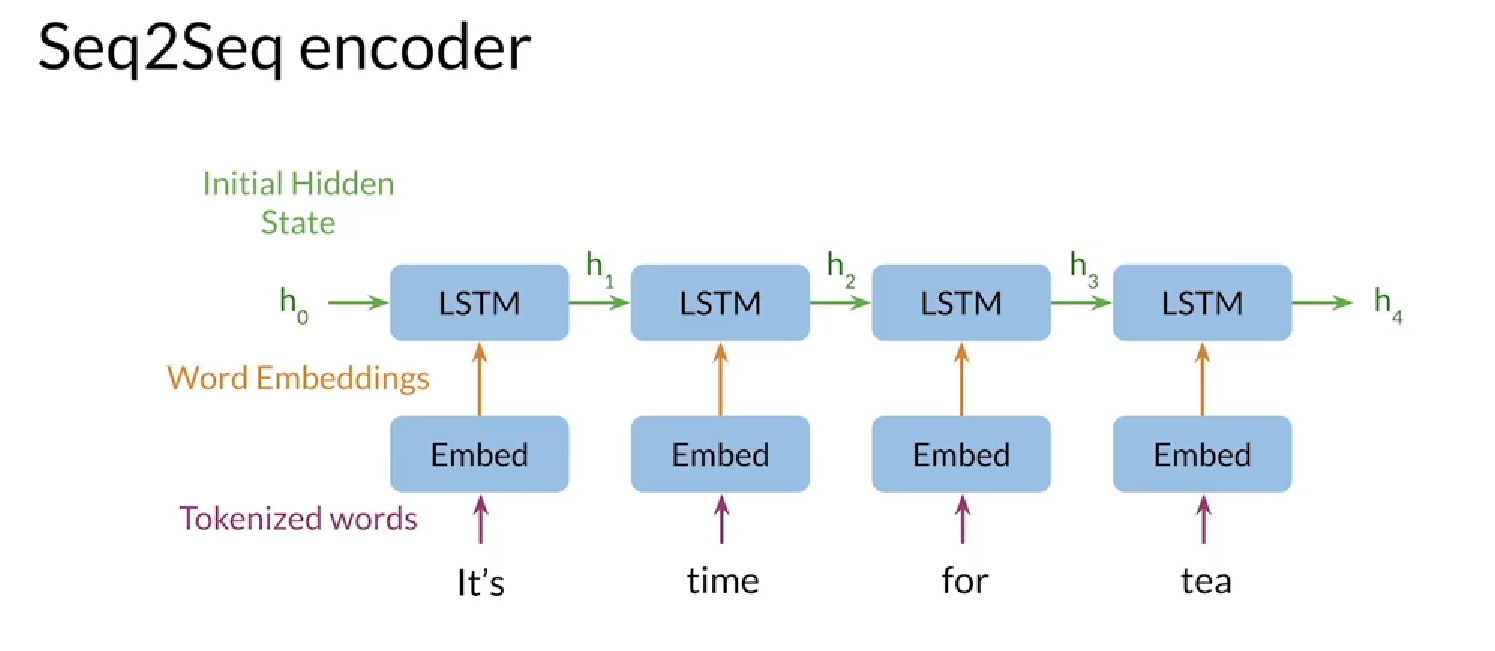

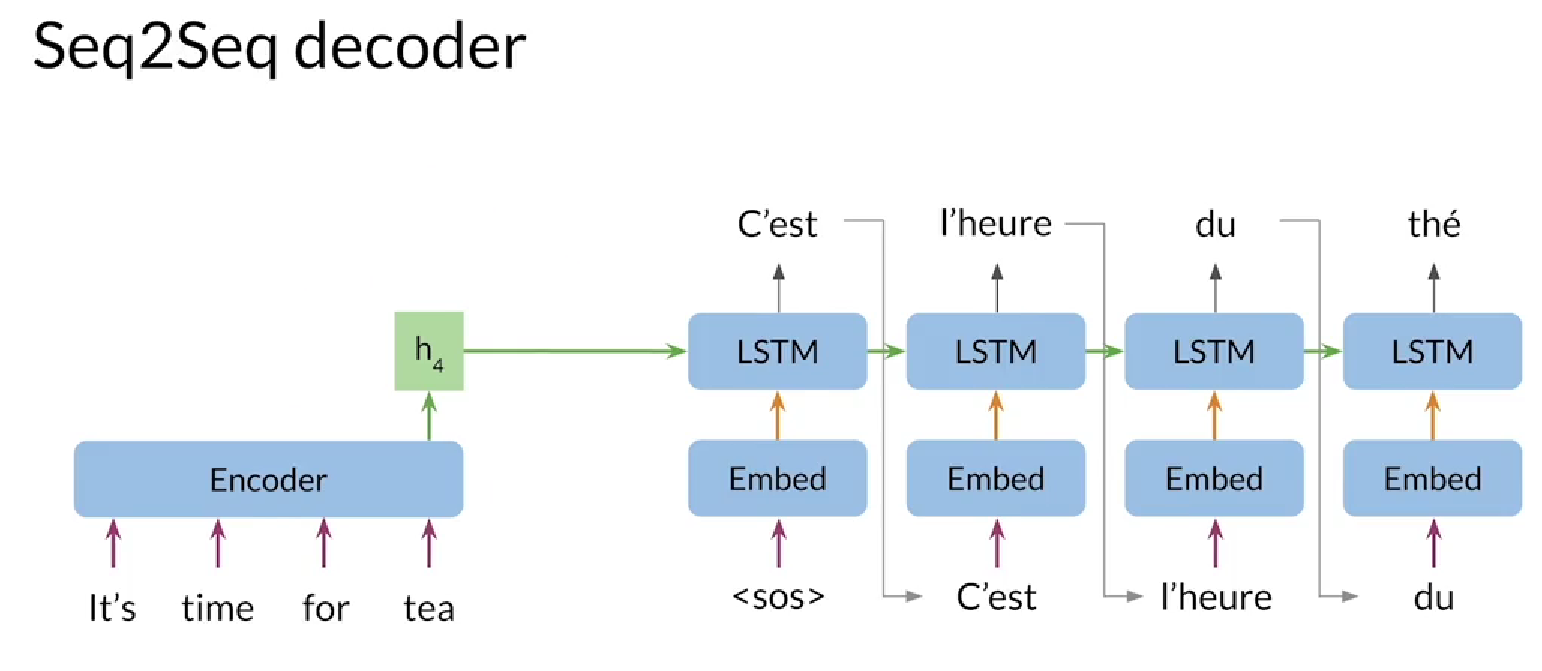

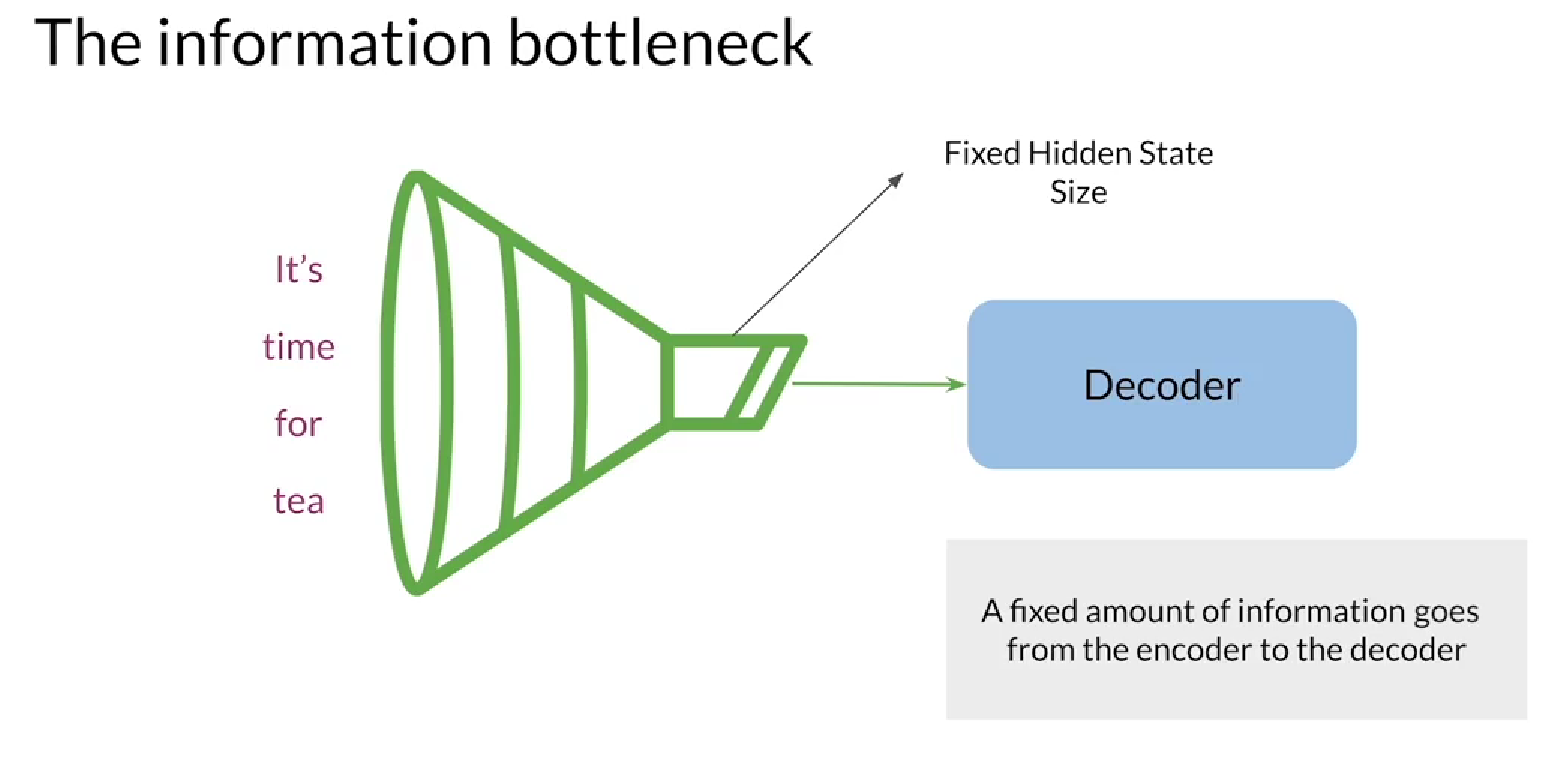

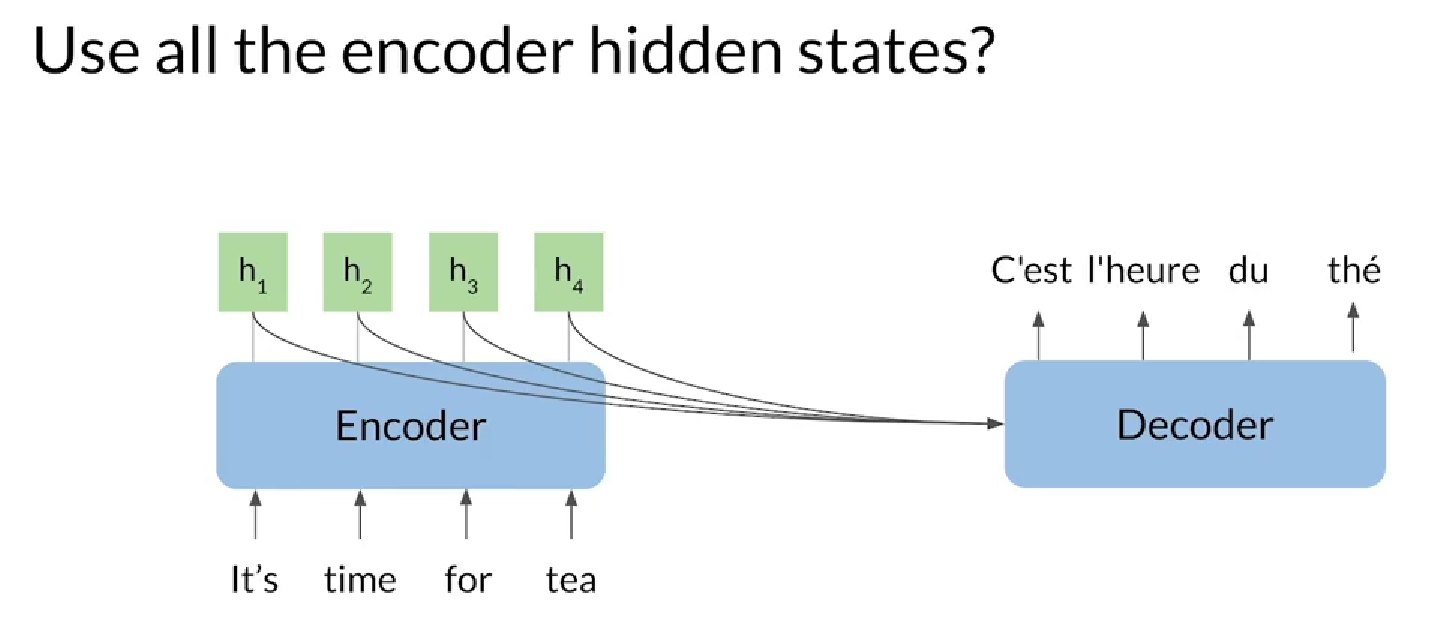

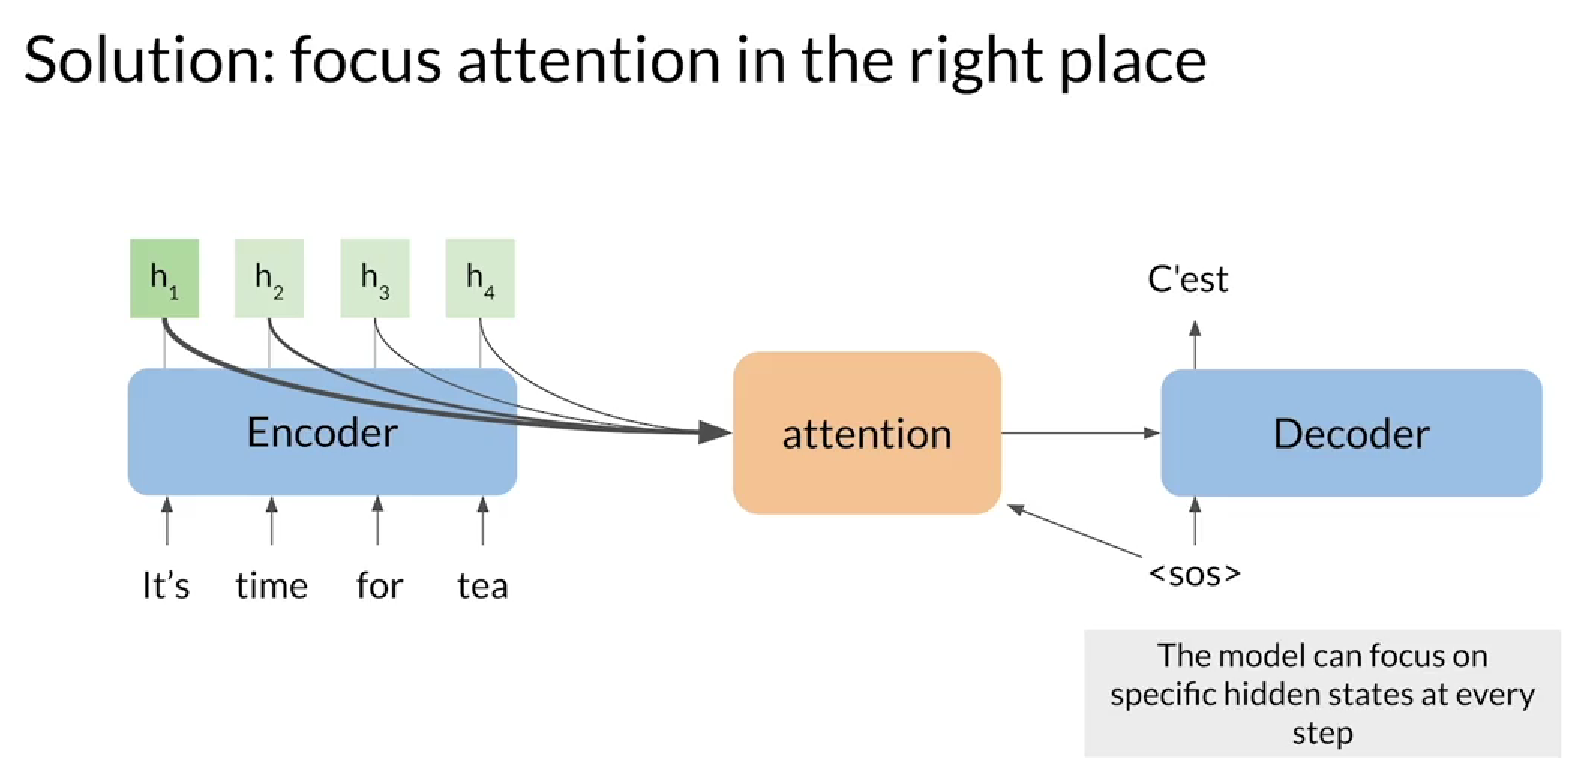

## Basic Attention

In [ ]:
def softmax(x, axis=0):
    """ Calculate softmax function for an array x along specified axis
    
        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


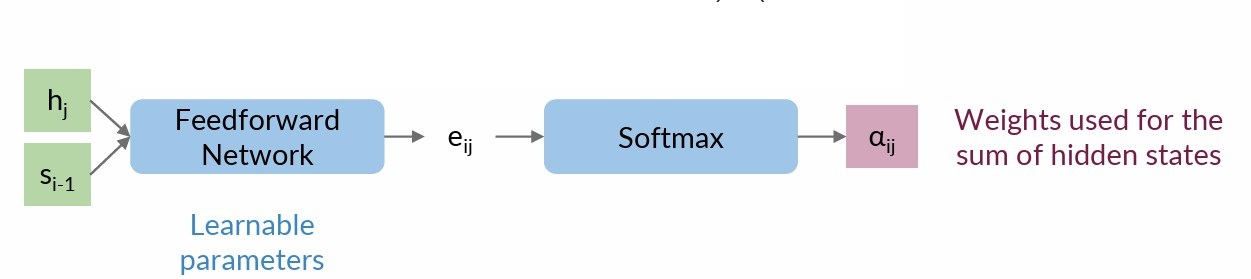

In [ ]:
hidden_size = 16
attention_size = 10
input_length = 5

np.random.seed(42)

# Synthetic vectors used to test
encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

# Weights for the neural network, these are typically learned through training
# Use these in the alignment function below as the layer weights
layer_1 = np.random.randn(2 * hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

# Calculating alignment scores
def alignment(encoder_states, decoder_state):
    # First, concatenate the encoder states and the decoder state
    inputs = np.concatenate((encoder_states, decoder_state.repeat(encoder_states.shape[0], axis=0)), axis=1)
    assert inputs.shape == (input_length, 2 * hidden_size)
    
    # Matrix multiplication of the concatenated inputs and layer_1, with tanh activation
    activations = tanh(np.dot(inputs, layer_1))
    assert activations.shape == (input_length, attention_size)
    
    # Matrix multiplication of the activations with layer_2. Remember that you don't need tanh here
    scores = np.dot(activations, layer_2)
    assert scores.shape == (input_length, 1)
    
    return scores

In [ ]:
# Turning alignment into weights + Weight the encoder output vectors and sum
def attention(encoder_states, decoder_state):
    """ Example function that calculates attention, returns the context vector 
    
        Arguments:
        encoder_vectors: NxM numpy array, where N is the number of vectors and M is the vector length
        decoder_vector: 1xM numpy array, M is the vector length, much be the same M as encoder_vectors
    """ 
    
    # First, calculate the alignment scores
    scores = alignment(encoder_states, decoder_state)
    
    # Then take the softmax of the alignment scores to get a weight distribution
    weights = softmax(scores)
    
    # Multiply each encoder state by its respective weight
    weighted_scores = encoder_states * weights.repeat(encoder_states.shape[1], axis=1)
    
    # Sum up weighted alignment vectors to get the context vector and return it
    context = np.sum(weighted_scores, axis=0)
    return context

context_vector = attention(encoder_states, decoder_state)
print(context_vector)

### The similarity between words is called **alignment**. 

The query and key vectors are used to calculate alignment scores that are measures of how well the query and keys match. These alignment scores are then turned into weights used for awaited, sum of the value vectors, this weighted sum of the value vectors is returned as the **attention vector**.

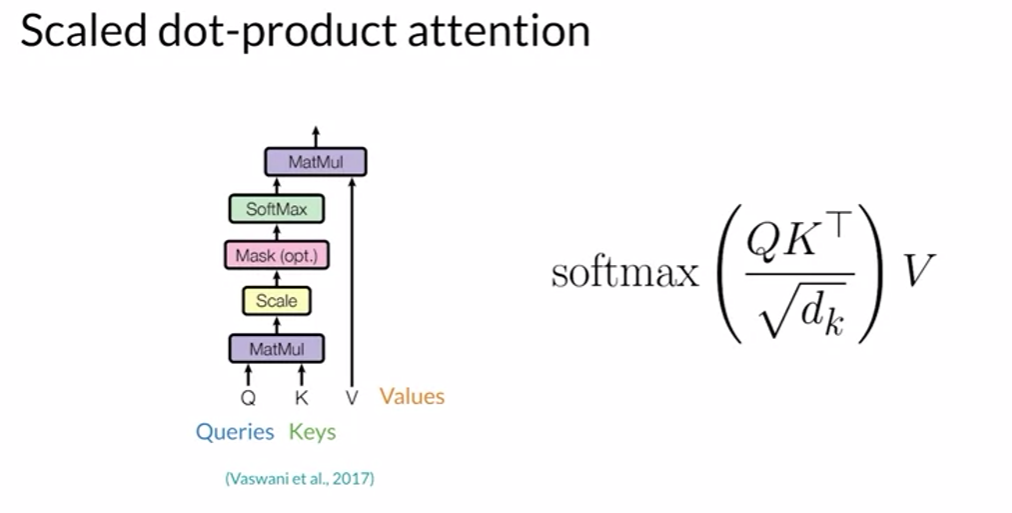

1. The queries and keys matrices are multiplied together to get a matrix of alignments course
2. These are then scaled by the square root of the key vector dimension, dk the scaling improves the model performance for larger model sizes and could be seen as a regularization constants.
3. Next the scale scores are converted to weights using the softmax function. Such that the weights for each query sum to one. 
4. Finally the weights and the value matrices are multiplied to get the attention vectors for each query, you can think of the keys and the values as being the same. So when you multiply the softmax output with V you are taking a linear combination of your initial input which is then being fed to the decoder. 

When the attention mechanism assigns a higher attention score to a certain word in the sequence - the next word in the decoder's output will be more strongly influenced by this word than by other words in the sequence.

## Scaled Dot-Product Attention (Queries, Keys, Values)

In [ ]:
# Load the word2int dictionaries
with open("./input_data/word2int_en.pkl", "rb") as f:
    en_words = pickle.load(f)
    
with open("./input_data/word2int_fr.pkl", "rb") as f:
    fr_words = pickle.load(f)

# Load the word embeddings
en_embeddings = np.load("./input_data/embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./input_data/embeddings_fr.npz")["embeddings"]

In [ ]:
def tokenize(sentence, token_mapping):
    tokenized = []
    
    for word in sentence.lower().split(" "):
        try:
            tokenized.append(token_mapping[word])
        except KeyError:
            # Using -1 to indicate an unknown word
            tokenized.append(-1)
        
    return tokenized


def embed(tokens, embeddings):
    embed_size = embeddings.shape[1]
    
    output = np.zeros((len(tokens), embed_size))
    for i, token in enumerate(tokens):
        if token == -1:
            output[i] = np.zeros((1, embed_size))
        else:
            output[i] = embeddings[token]
            
    return output

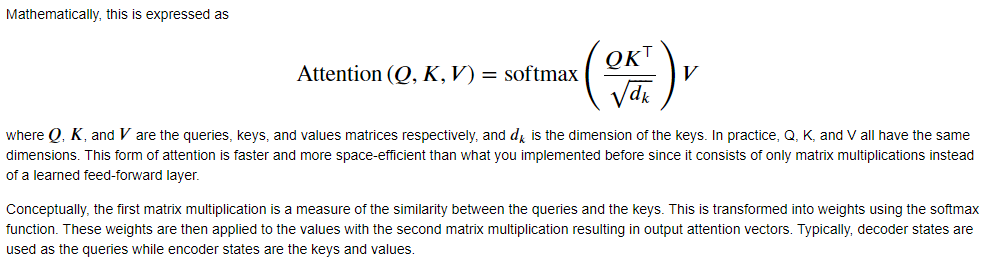

In [ ]:
def softmax(x, axis=0):    
    """ Calculate softmax function for an array x

        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis=axis)

def calculate_weights(queries, keys):
    """ Calculate the weights for scaled dot-product attention"""
    dot = np.matmul(queries, keys.T) / np.sqrt(keys.shape[1])
    weights = softmax(dot, axis=1)
    
    assert weights.sum(axis=1)[0] == 1, "Each row in weights must sum to 1"
    
    return weights

In [ ]:
# Tokenize example sentences in English and French, then get their embeddings
sentence_en = "The agreement on the European Economic Area was signed in August 1992 ."
tokenized_en = tokenize(sentence_en, en_words)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "L accord sur la zone économique européenne a été signé en août 1992 ."
tokenized_fr = tokenize(sentence_fr, fr_words)
embedded_fr = embed(tokenized_fr, fr_embeddings)

# These weights indicate alignment between words in English and French
alignment = calculate_weights(embedded_fr, embedded_en)

# Visualize weights to check for alignment
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(alignment, cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=16);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=16);

In [ ]:
def attention_qkv(queries, keys, values):
    """ Calculate scaled dot-product attention from queries, keys, and values matrices """
    
    # Replace pass with your code.
    return np.matmul(calculate_weights(queries, keys), values)


attention_qkv_result = attention_qkv(embedded_fr, embedded_en, embedded_en)

print(f"The shape of the attention_qkv function is {attention_qkv_result.shape}")
print(f"Some elements of the attention_qkv function are \n{attention_qkv_result[0:2,:10]}")

## Teacher Forcing

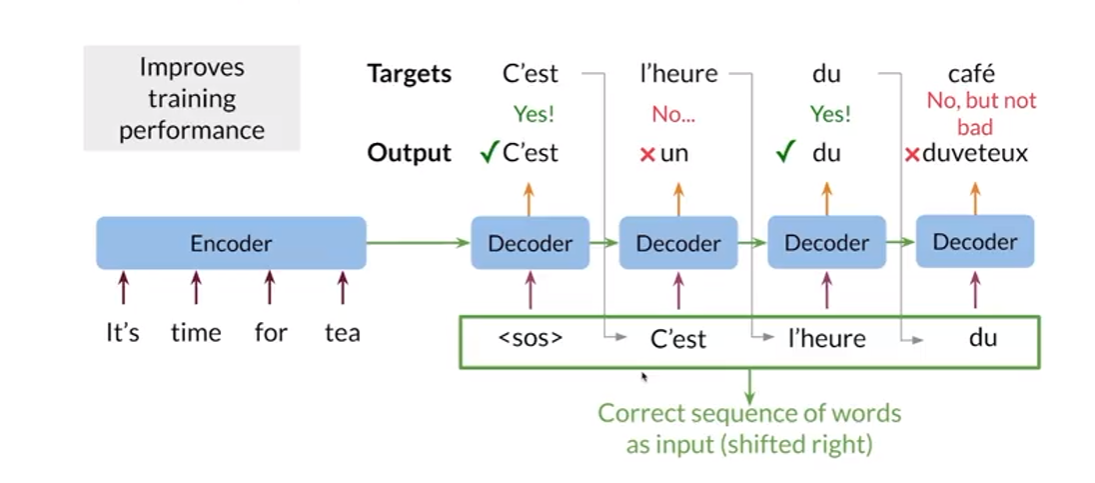

## Neural Machine Translation

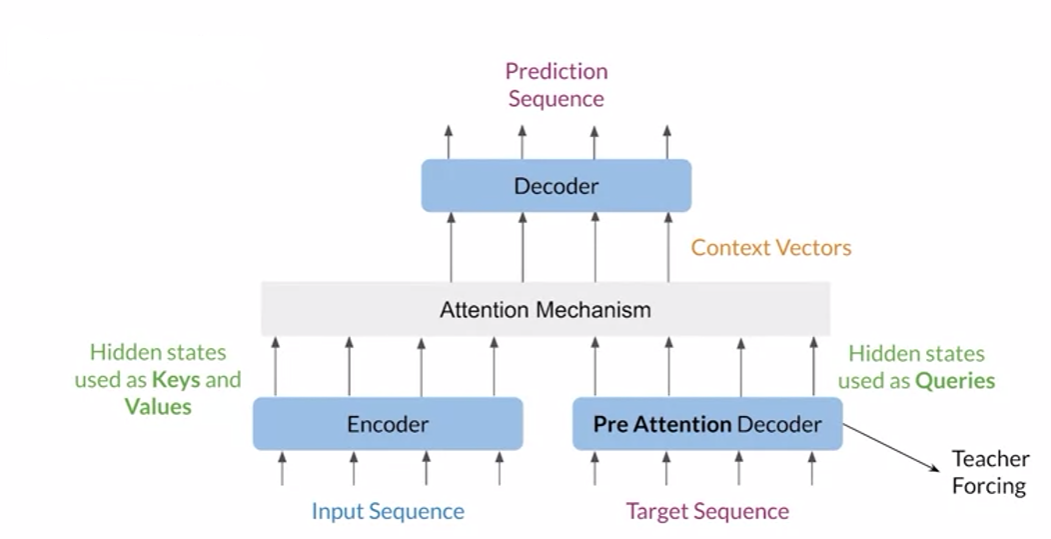

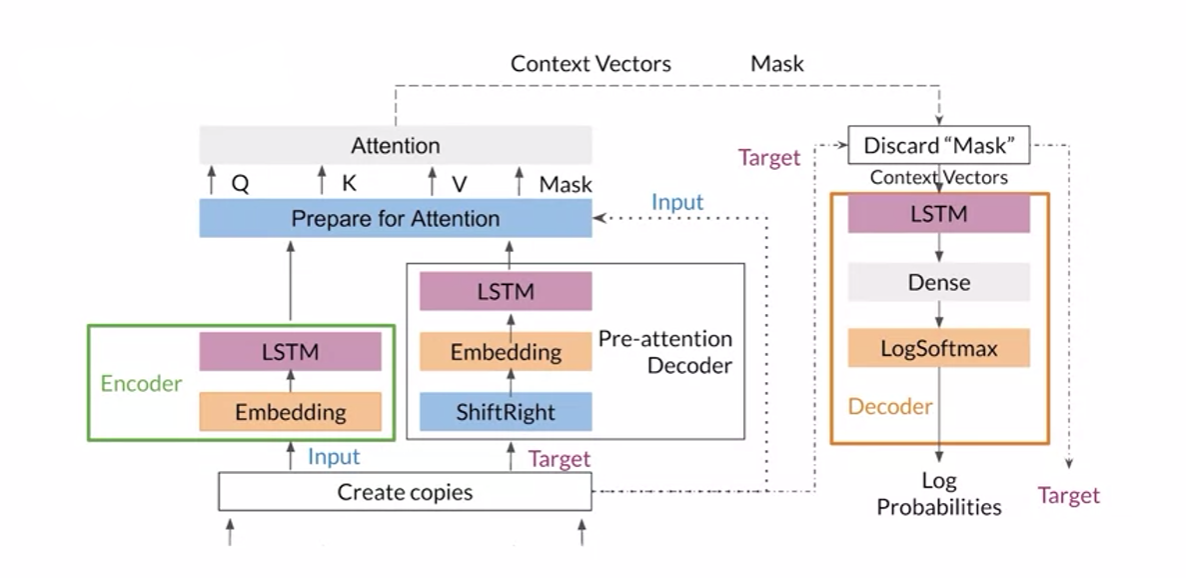

1. The initial step is to make two copies of the input tokens and the target tokens because you will need them in different places of the model. 
2. One copy of the input tokens is fed into the encoder, which is used to transform them into the key and value vectors, 
3. while a copy of the target tokens goes into the pre-attention decoder. Note that the computations done in the encoder and pre-attention decoder could be done in parallel, since they don't depend on each other. Within the pre-attention decoder, you shift each sequence to the right and add a start of sentence token. 
* In the encoder and pre-attention decoder, the inputs and targets go through an embedding layer before going to LSTMs. 
4. After getting the query key and value vectors, you have to prepare them for the attention layer. You'll use a function to help you get a padding mask to help the attention layer determine the padding tokens. This step is where you will use the copy of the input tokens. 
5. Now, everything is ready for attention. You pass the queries, keys, values, and the mask to the attention layer that outputs the context vector and the mask. 
6. Before going through the decoder, you drop the mask. You then pass the context vectors through the decoder composed of an LSTM, a dense layer, and a LogSoftmax. 
7. In the end, your model returns log probabilities and the copy of the target tokens that you made at the beginning. 

There you have it, the model you'll be building and the intuition behind all the steps. 

## Bilingual Evaluation Understudy (BLEU) Score

The BLEU score, a bilingual evaluation understudy, is an algorithm designed to evaluate some of the most challenging problems in NLP, including machine translation. It evaluates the quality of machine-translated text by comparing a candidate translation to one or more references, which are often human translations. 

The closer the BLEU score is to 1, the better your model is, the closer to 0, the worse it is. 

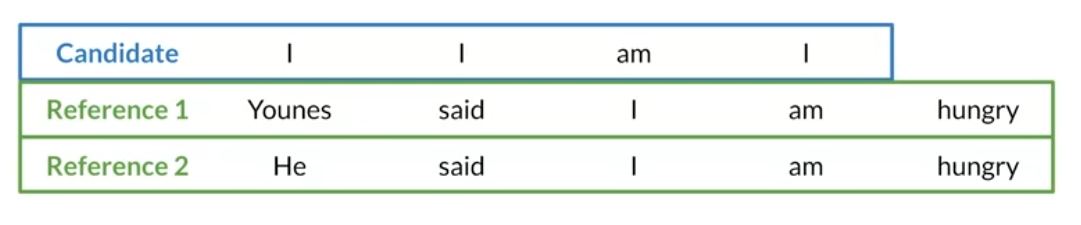

To get the BLEU score, you count how many words from the candidate appear in any of the references and divide that count by the total number of words in the candidate translation. You can view it as a precision metric. You have to go through all the words in the candidate translation.

1. First, you have the word I, which appears in both reference translations. You add one to your count. 
2. Then you have again the word I, which you already know appears on both references, and you add one to your count. 
3. After that, you have the word am which also appears in both references. You add that word to your count. 
4. At the end, you have the word I again, which appears on both references. You can add one to your count. 
5. Finally, you can get the BLEU score by dividing your count by the number of words in the candidate translation, which in this case is equal to 4. The whole process gives you a BLEU score equal to 1. 

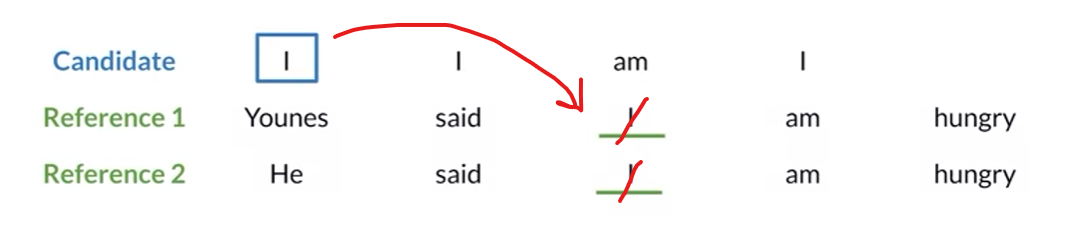

For the **modified version of the BLEU score**, after you find a word from the candidates in one or more of the references, you stop considering that word from the reference for the following words in the candidates. In other words, you exhaust the words in the references after you match them with a word in the candidates. Let's start from the beginning of the candidate translation. 

1. You have the word I that appears in both references. You add one to your count and exhaust the word I from both references. 
2. Then you have the word I again, but you don't have that word in the references because it was taken out for the previous word in the candidate. You don't add anything to your count. 
3. Then you have the word AM, which appears in both references. You add one to your counts and eliminate the word M from both references. 
4. After that, you have the word I again, but no left occurrences in the references. You don't add anything to your counts. 
5. Finally, you divide your count by the number of words in the candidate translation to get BLEU score of 2/4 or 0.5. 

As you can note, this version of the BLEU score makes more sense than the vanilla implementation. However, like anything in life, using the BLEU score as an evaluation metric has some caveats. For one, it doesn't consider the semantic meaning of the words. It also doesn't consider the structure of the sentence. Imagine getting this translation. Ate I was hungry because. If the reference sentence is I ate because I was hungry, this would get a perfect BLEU score. BLEU score is the most widely adopted evaluation metric for machine translation. But you should be aware of these drawbacks before using it. 

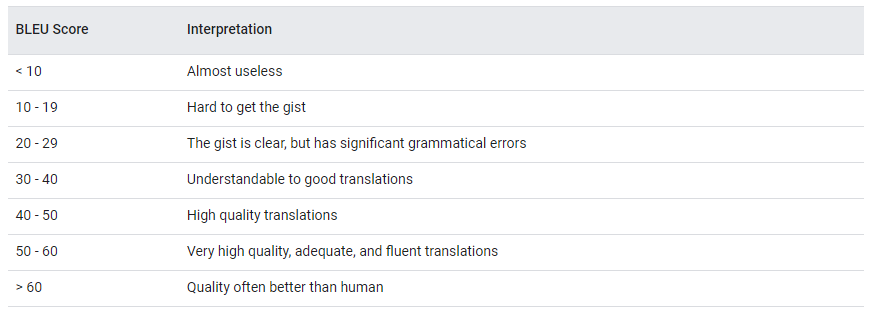

In [ ]:
import numpy as np                  # import numpy to make numerical computations.
import nltk                         # import NLTK to handle simple NL tasks like tokenization.
nltk.download("punkt")
from nltk.util import ngrams
from collections import Counter     # import a counter.
!pip3 install 'sacrebleu'           # install the sacrebleu package.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.
import matplotlib.pyplot as plt     # import pyplot in order to make some illustrations.

### Brevity Penalty:
The brevity penalty penalizes generated translations that are shorter than the reference sentence. It compensates for the fact that the BLEU score has no recall term.

In [ ]:
reference_length = 1
candidate_length = np.linspace(1.5, 0.5, 100)

length_ratio = reference_length / candidate_length
BP = np.minimum(1, np.exp(1 - length_ratio))

# Plot the data
fig, ax = plt.subplots(1)
lines = ax.plot(length_ratio, BP)
ax.set(
    xlabel="Ratio of the length of the reference to the candidate text",
    ylabel="Brevity Penalty",
)
plt.show()

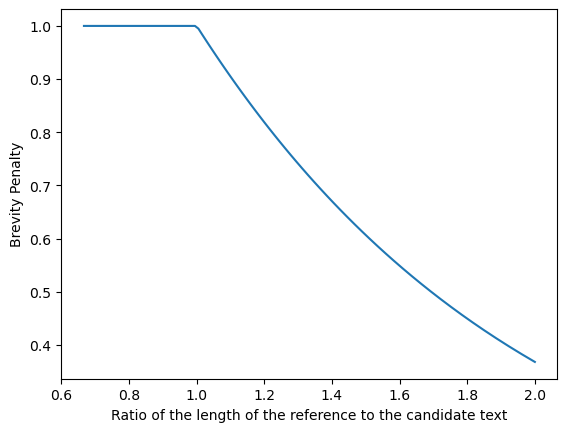

### N-Gram Precision:
The n-gram precision counts how many n-grams (in your case unigrams, bigrams, trigrams, and four-grams for i =1 , ... , 4) match their n-gram counterpart in the reference translations. This term acts as a precision metric. Unigrams account for adequacy while longer n-grams account for fluency of the translation. To avoid overcounting, the n-gram counts are clipped to the maximal n-gram count occurring in the reference. Typically precision shows exponential decay with the degree of the n-gram.

In [ ]:
# Mocked dataset showing the precision for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.7, "3-gram": 0.6, "4-gram": 0.5}

# Plot the datapoints defined above
fig, ax = plt.subplots(1)
bars = ax.bar(*zip(*data.items()))
ax.set(ylabel="N-gram precision")
plt.show()

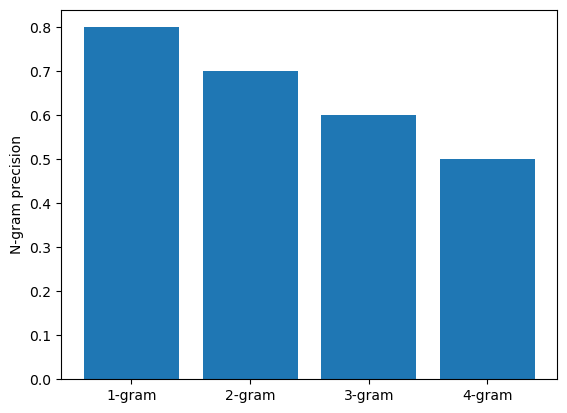

### N-gram BLEU score:
When the n-gram precision is normalized by the brevity penalty (BP), then the exponential decay of n-grams is almost fully compensated. The BLEU score corresponds to a geometric average of this modified n-gram precision.

In [ ]:
# Mocked dataset showing the precision multiplied by the BP for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.77, "3-gram": 0.74, "4-gram": 0.71}

# Plot the datapoints defined above
fig, ax = plt.subplots(1)
bars = ax.bar(*zip(*data.items()))
ax.set(ylabel="Modified N-gram precision")
plt.show()

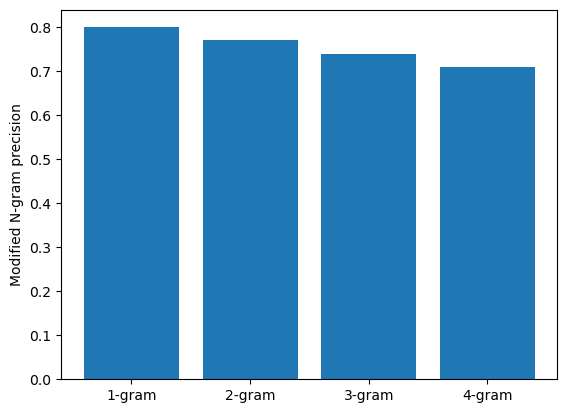

### Calculations of the BLEU score

In [ ]:
# Define and tokenize the sentences

reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

In [ ]:
# Computing the Brevity Penalty

def brevity_penalty(candidate, reference):
    """
    Calculates the brevity penalty given the candidate and reference sentences.
    """
    reference_length = len(reference)
    candidate_length = len(candidate)

    if reference_length < candidate_length:
        BP = 1
    else:
        penalty = 1 - (reference_length / candidate_length)
        BP = np.exp(penalty)

    return BP

In [ ]:
# Computing the clipped Precision

def average_clipped_precision(candidate, reference):
    """
    Calculates the precision given the candidate and reference sentences.

    The function calculates how many of the n-grams in the candidate sentence actually appear in the reference sentence. 
    The clipping takes care of overcounting. For example if a certain n-gram appears five times in the candidate sentence, 
    but only twice in the reference, the value is clipped to two.
    """

    clipped_precision_score = []
    
    # Loop through values 1, 2, 3, 4. This is the length of n-grams
    for n_gram_length in range(1, 5):
        reference_n_gram_counts = Counter(ngrams(reference, n_gram_length))        
        candidate_n_gram_counts = Counter(ngrams(candidate, n_gram_length))                

        total_candidate_ngrams = sum(candidate_n_gram_counts.values())       
        
        for ngram in candidate_n_gram_counts: 
            # check if it is in the reference n-gram
            if ngram in reference_n_gram_counts:
                # if the count of the candidate n-gram is bigger than the corresponding
                # count in the reference n-gram, then set the count of the candidate n-gram 
                # to be equal to the reference n-gram
                
                if candidate_n_gram_counts[ngram] > reference_n_gram_counts[ngram]: 
                    candidate_n_gram_counts[ngram] = reference_n_gram_counts[ngram] # t
                                                   
            else:
                candidate_n_gram_counts[ngram] = 0 # else set the candidate n-gram equal to zero

        clipped_candidate_ngrams = sum(candidate_n_gram_counts.values())
        
        clipped_precision_score.append(clipped_candidate_ngrams / total_candidate_ngrams)
    
    # Calculate the geometric average: take the mean of elemntwise log, then exponentiate
    # This is equivalent to taking the n-th root of the product as shown in equation (1) above
    s = np.exp(np.mean(np.log(clipped_precision_score)))
    
    return s


In [ ]:
# Computing the BLEU score

def bleu_score(candidate, reference):
    BP = brevity_penalty(candidate, reference)    
    geometric_average_precision = average_clipped_precision(candidate, reference)    
    return BP * geometric_average_precision

In [ ]:
# Testing the functions

result_candidate_1 = round(bleu_score(tokenized_cand_1, tokenized_ref) * 100, 1)
print(f"BLEU score of reference versus candidate 1: {result_candidate_1}")
result_candidate_2 = round(bleu_score(tokenized_cand_2, tokenized_ref) * 100, 1)
print(f"BLEU score of reference versus candidate 2: {result_candidate_2}")

# the same calculation, but using the sacrebleu library. Compare them with your implementation above.

# result_candidate_1 = round(sacrebleu.sentence_bleu(candidate_1, [reference]).score, 1)
# print(f"BLEU score of reference versus candidate 1: {result_candidate_1}")
# result_candidate_2 = round(sacrebleu.sentence_bleu(candidate_2, [reference]).score, 1)
# print(f"BLEU score of reference versus candidate 2: {result_candidate_2}")

## Recall-Oriented Understudy for Gisting Evaluation (ROUGE-N) Score

Performance metric that tends to estimate the quality of machine translation systems. 

It's more recall-oriented by default. That means that ROUGE cares about how much of the human created references appear in the candidate translation. In contrast, BLEU is precision oriented. Since you have to determine how many words from the candidates appear on the references. 

ROUGE was initially developed to evaluate the quality of the machine summarized texts, but is also helpful in assessing the quality of machine translation. It works by comparing the machine candidates against reference translations provided by humans. There are many versions of the ROUGE score, but also the one called ROUGE-N. For the ROUGE-N score, You have to get the counts of the n-gram overlaps between the candidates and the reference translations, which is somewhat similar to what you have to do for the BLEU score. 


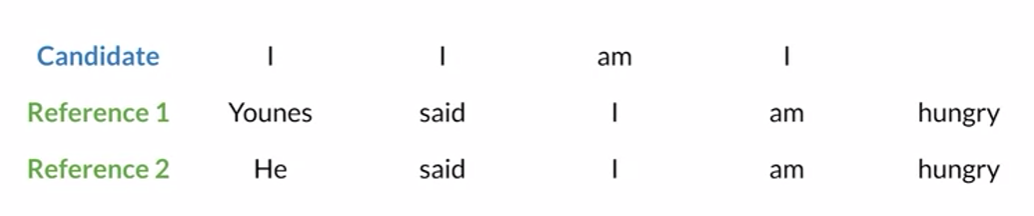

How ROUGE-N works with uni-grams. To get the basic version of the ROUGE-N score based only on recall so you must count word matches between the reference and the candidates, and divide by the number of words in the reference. If you had multiple references, you would need to get a ROUGE-N score using each reference and get the maximum. 

* Your candidate has the words I two times, the word AM, and the word I again, for a total of four words. 

* You also have a reference translation. "Younes said I am hungry" and another slightly different reference. "He said I am hungry." Each reference has five words in total. You have to count matches between the references and the candidate translations, similar to what you did for the BLEU score. 



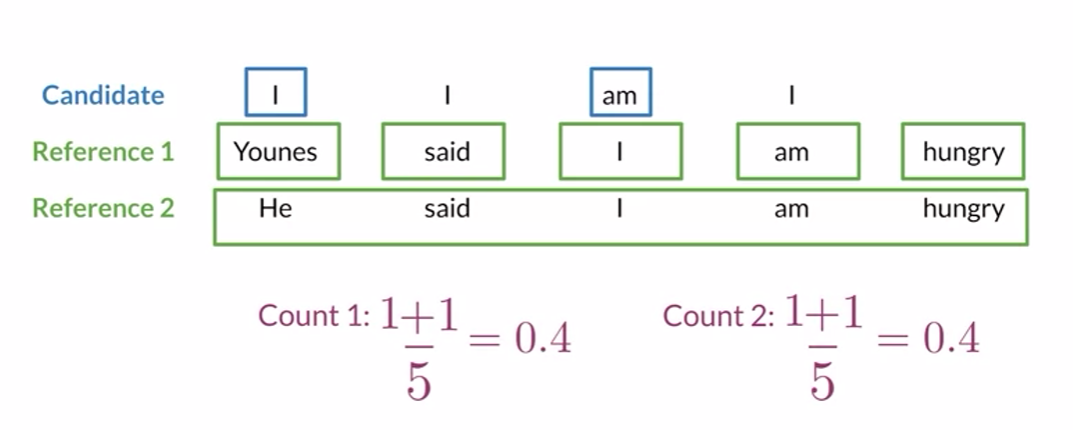

0. Let's start with the first reference. 
1. The word Younes, doesn't match any of the uni-grams in the candidates, so you don't add anything to the counts. 
2. The word said doesn't match any word and the candidates either. 
3. The word I, has multiple matches, but you need the first one. For this match, you add only one to your counts. 
4. The word AM has a match in the candidates so your increment your counts. 
5. Now, the final word of the first reference, hungry, doesn't match any of the words from the candidates. You don't add anything to your counts. 
6. If you repeat this process for the second reference, you get a counts equal to 2. 
7. Finally, you divide these counts by the number of words in each reference and get the maximum value, which for this example is equal to 0.4. 

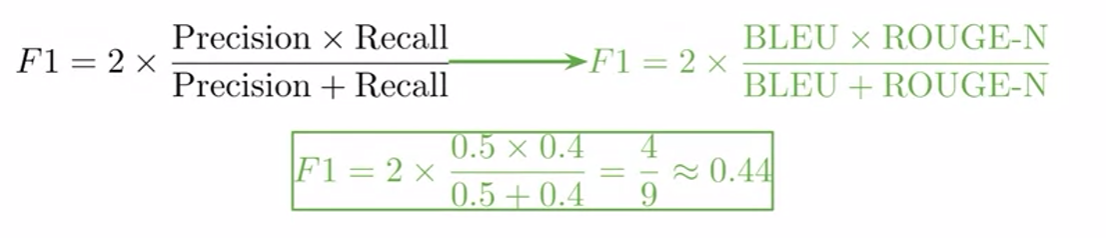

This basic version of the ROUGE-N score is based on recall while the BLEU score you saw in the previous lectures is precision. But why not combine both to get a metric like an F1 score. You can use an F1 score that's could better assess the performance of your machine translation model. However, you must note that's all the evaluation metrics you have seen so far, don't consider the sentence structure and semantics, only accounts for matching n-grams between candidates and the reference translations. 

## Sampling and Decoding

Two ways that will allow you to construct a sentence. 
* greedy decoding 
* random sampling 

### *First, a quick reminder on how a seq2seq model predicts words. The output of the decoder is produced from a dense layer and a softmax or log softmax operation. The output at each step then is the probability distribution over all the words and symbols in the target vocabulary. The final output of the model depends on how you choose the words using these probability distributions at each step.*

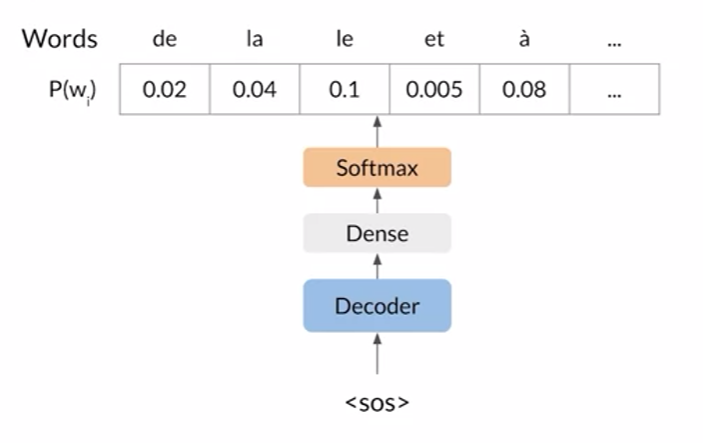

**Greedy decoding** is the simplest way to decode the model's predictions as it selects the most probable word at every step. However, this approach has limitations. When you consider the highest probability for each prediction and concatenate all predicted tokens for the output sequence. As the greedy decoder does, you can end up with a situation where the output instead of, "I am hungry," gives you "I am, am, am" and so forth. You can see how this could be a problem, but not in all cases. For shorter sequences, it's going to be fine. But if you have many other words to consider, then knowing what's coming up next might help you better predict the next sequence. 

Another option is known as **random sampling**. What random sampling does is it provides probabilities for each word and sample accordingly for the next outputs. One of the problems with this is that it could be a little bit too random. A solution for this is to assign more weight to the words with higher probabilities and less weight to the others. You will see a method for doing this in just a few moment. 

In sampling, **temperature** is a parameter you can adjust to allow for more or less randomness in your predictions. It's measured on a scale of 0-1, indicating low to high randomness. 
* Let's say you need your model to make careful, safe decisions about what to output. Then set you're parameter lower and get the prediction equivalent of a very confident but rather a boring person seated next to you at a dinner table. 
* If you feel like taking more of a gamble, set your temperature a bit higher. This has the effect of making your network more excited. You may get some pretty fun predictions. On the other hand, there will be probably a lot more mistakes.

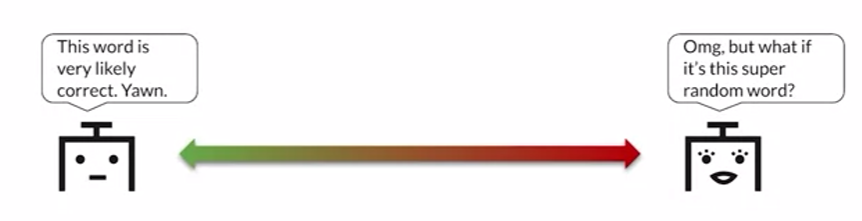

## Beam Search

**Beam search** is a technique that allows you to find the best sequences over a fixed window size known as the beam with. Since taking the output with the highest probability at each time step is not ideal. 

This method attempts to find the most likely outsports sentence by choosing some number of best sequences based on conditional probabilities at each time step.

Now at each time step with beam search you have to calculate the probability of potential sequences given the outputs of the previous time step.

To avoid computing the probability for every possible sequence you have armature B called the beam width. At each step, you only keep the most probable sequences and drop all others. You generate a new word until all B most probable sentences and with the < EOS > token. So beam search consumes a lot of memory and could be computationally costly depending on your choice for beam. 

### *As an interesting side note, greedy decoding is just a particular case of beam search where you set the beam with B to be equal to 1.*

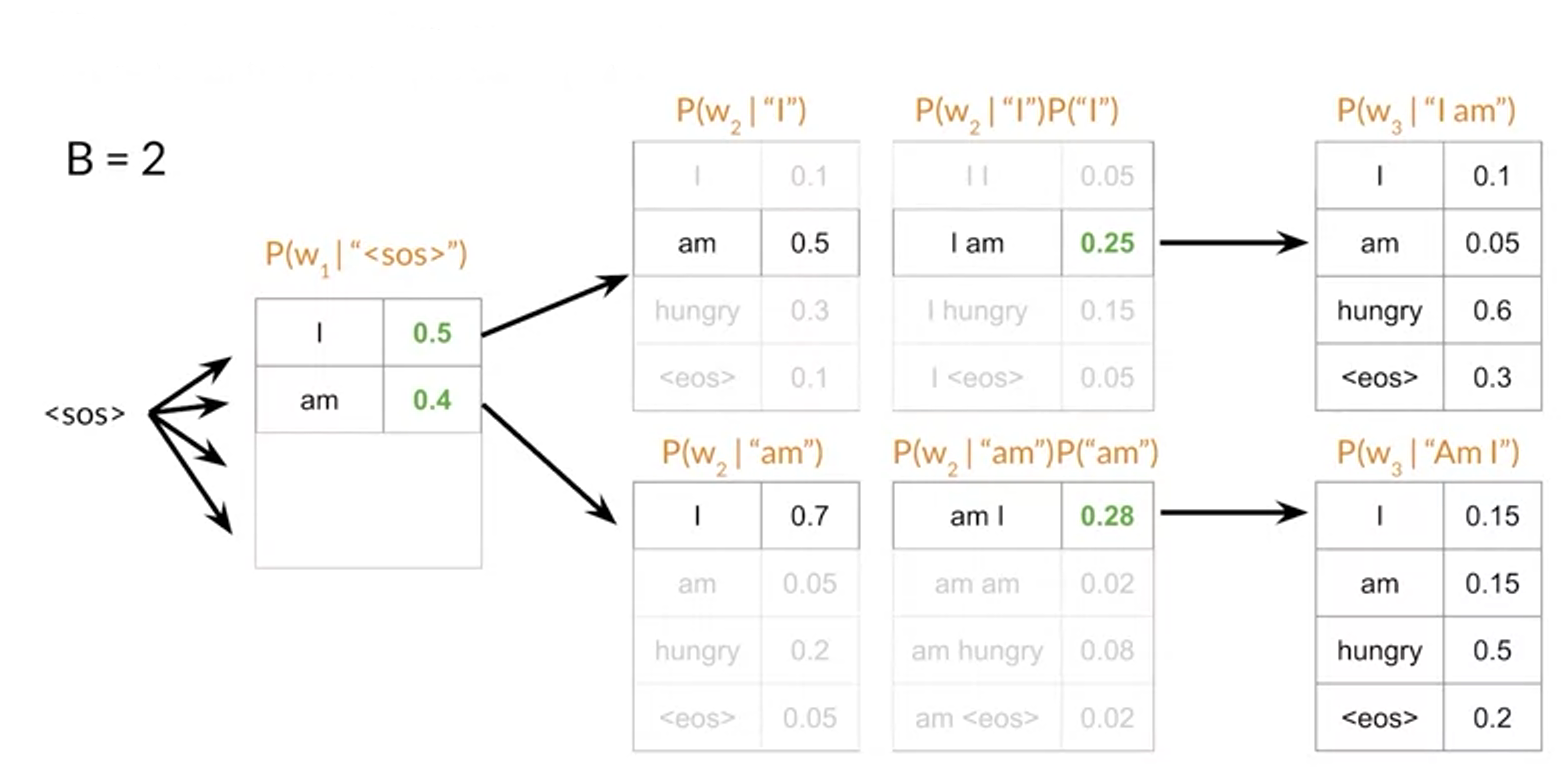

To illustrate this method, consider a small vocabulary consisting of the words I am hungry and an end of sentence token. And let's say the beam with B is equal to 2. As with the other methods beam search starts with the start of sentence token and gets the probabilities for the first word in the sequence. Here I has a probability of 0.5, am has a probability of 0.4 and hungry has a probability of 0.1 and in the eos is at 0. Since the beam with is 2 you keep the two highest probabilities I and am. Then you calculate the conditional probability of all other words Given the two sequences that you have kept so far I and am. Given the word I, the model returns am with a probability of 0.5 and hungry with 0.3. Given the words am, the model returns the probability of word I with a probability of 0.7 and hungry with a probability of 0.2. These are the two conditional probabilities given the two previous sequences of B of word 2 given word 1. Next you calculate the probability by multiplying the conditional probability for 2 given the word I with the probability of words I. For instance if the sequence of II has a probability of 0.5 times 0.1 this is equal to 0.05. The sequence I am has a probability of 0.5 times 0.5 which is equal to 0.25.

You have to do the same with the sequences starting with the word am. Here the sequence MI has a probability of 0.4 times 0.7 which is equal to 0.28. At this point there is possible sequences but with the beam width B=2 you only keep the two sequences with the highest probabilities. So you keep the sequence I am and am I and drop all others.

Then for the next step you use am as the inputs were to get the conditional probabilities for the I am sequence and I for the am I sequence. You repeat the process to calculate the joints probabilities and again choose the best sequence. This process stops with the model predicts an end of sentence token for all, be most probable sequences. At the end, the sequence with the largest probability is chosen as the outputs. 

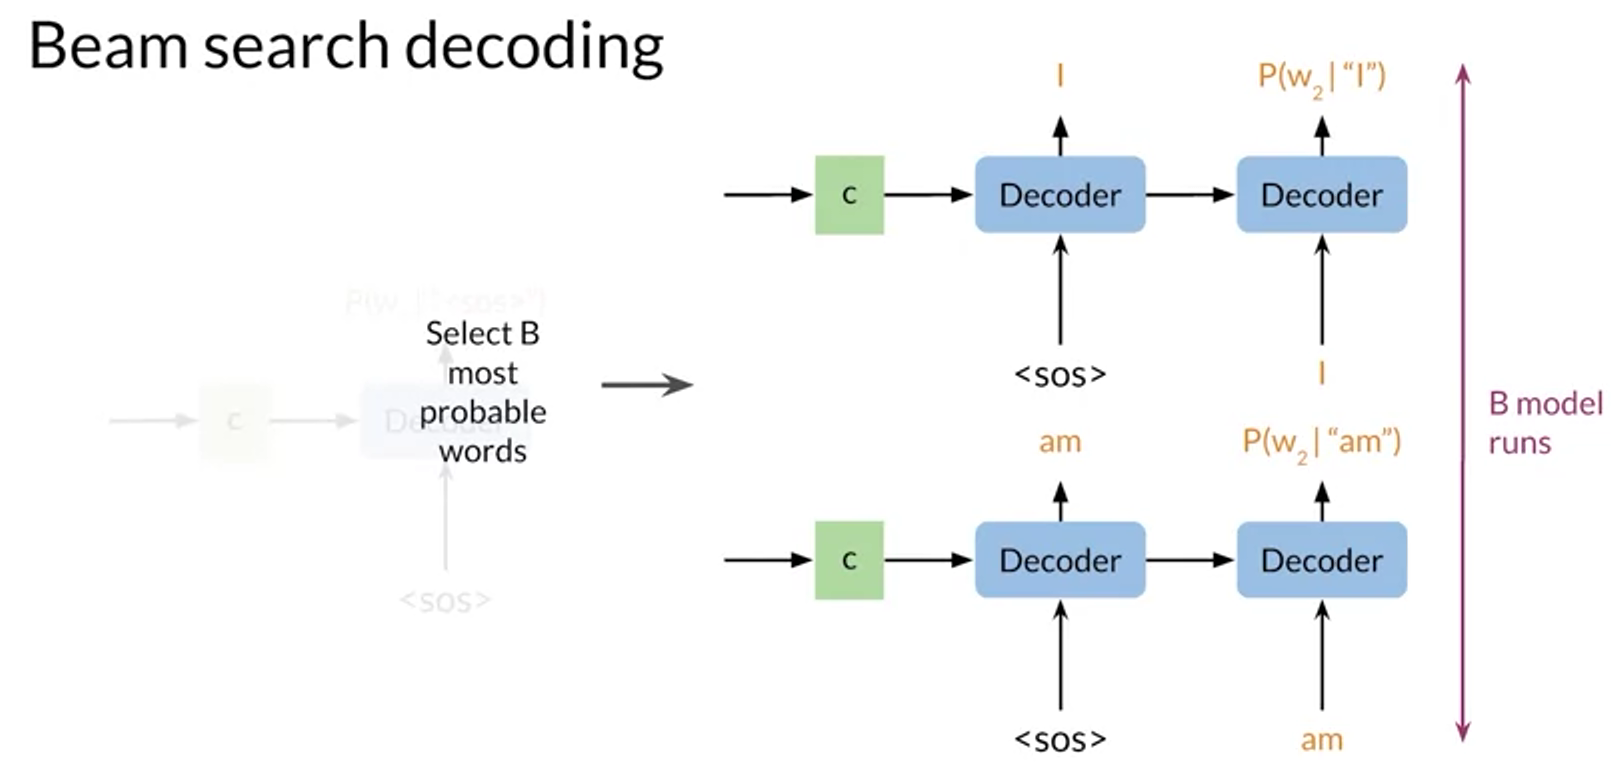

To get the conditional probabilities at each step you have to use your model. For now let's focus on the decoder parts of the model ignoring the encoder and attention mechanism. At the start of the sequence you will use your decoder to as a vector of probabilities for each of the words and the vocabulary. This is equivalent to computing the conditional probability of every word given the start of sequence token. Then you select the most probable B outputs from the model and discard all other possibilities. After that you use your model B times to find the conditional probabilities of all the words in the vocabulary given the sequences that you kept in the previous step. Then you compute the sequence probability and keep the B most probable sequences. And you keep doing this until the B most probable sequences gets to the end of the sequence token. Notes that at each step after the one where your sequence is only composed by the SOS token you have to run your model B times. 

The vanilla version of beam search has some disadvantages. For instance, it penalizes the choice of long wear sequences because the probability of a sequence is computed as the product of multiple conditional probabilities. However, you could normalize the probability of each sequence by its number four is to avoid this problem. Beam search also requires you to store the b most probable sequences and computes conditional probabilities given all of those sequences. Therefore, this method could be computationally expensive and consumes lots of memory. 

## Minimum Bayes Risk

It is very simple and works surprisingly well when compared to the other techniques, let's get started. Earlier, you encountered random sampling to choose a probable token and the issues with that decoding method. 
1. But if you go a little further with that, say by generating 30 samples and comparing them all against one another. You'll see quite a bit of improvements in your decoding. You'll have to compare multiple candidate translations for the minimum bayes risk decoding method, MBR for shorts. Implementing MBR is pretty straightforward. 
2. Begin by generating several random samples, then compare each sample against each other using a similarity score or a loss function. ROUGE would be a good choice that you may recall from a bit earlier.
3. Finally, choose the sample with the highest average similarity or the lowest loss. The translation that you get using this method is the closest to all candidate translations. This process can be viewed as some authors suggest, as finding a consensus between all candidate translations. 

If you decide to use ROUGE score as a similarity metric for comparing every pair of candidate translations, you would have MBR summarized in the formula presented here:

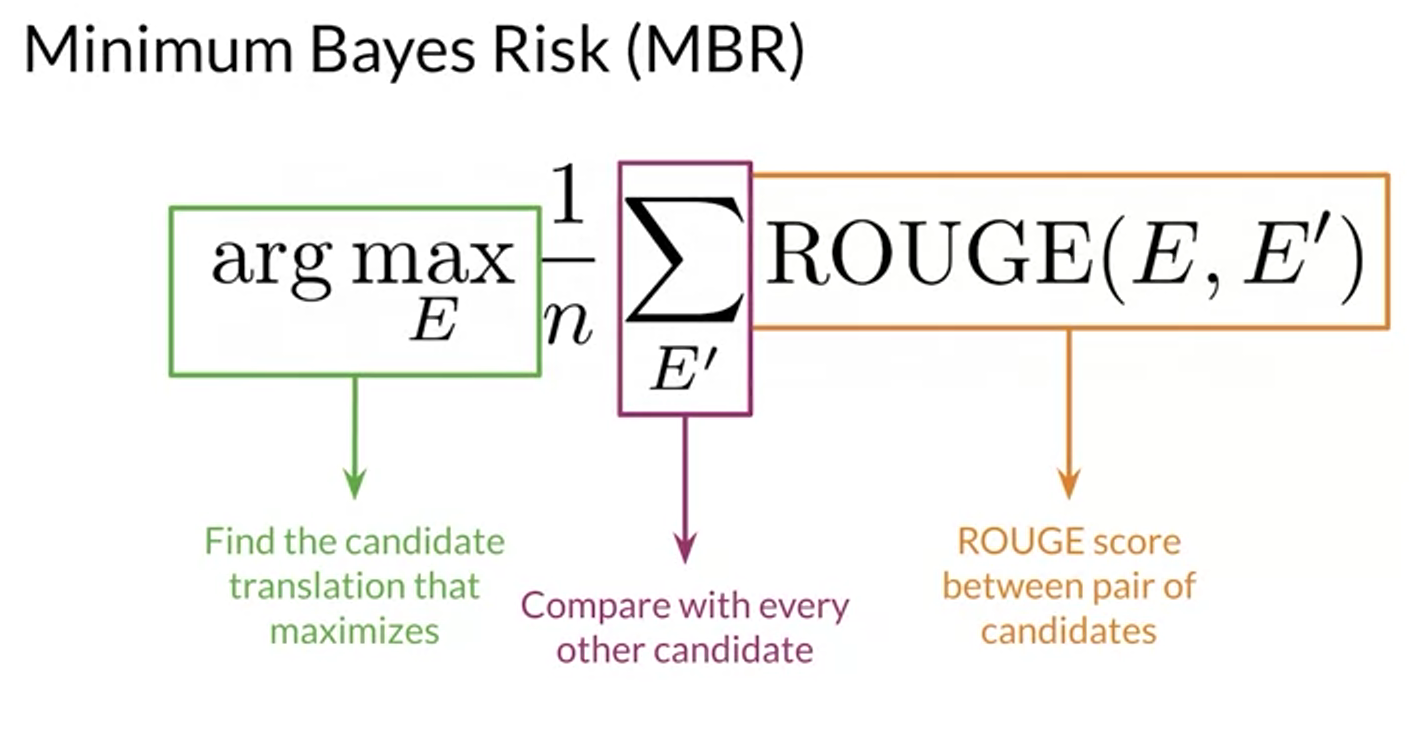


Your goal is to find the candidate translation E that maximizes the average ROUGE score with every other candidates E prime. So MBR is relatively easy to implement. You need to have multiple candidate translations and select a way to compare them. 

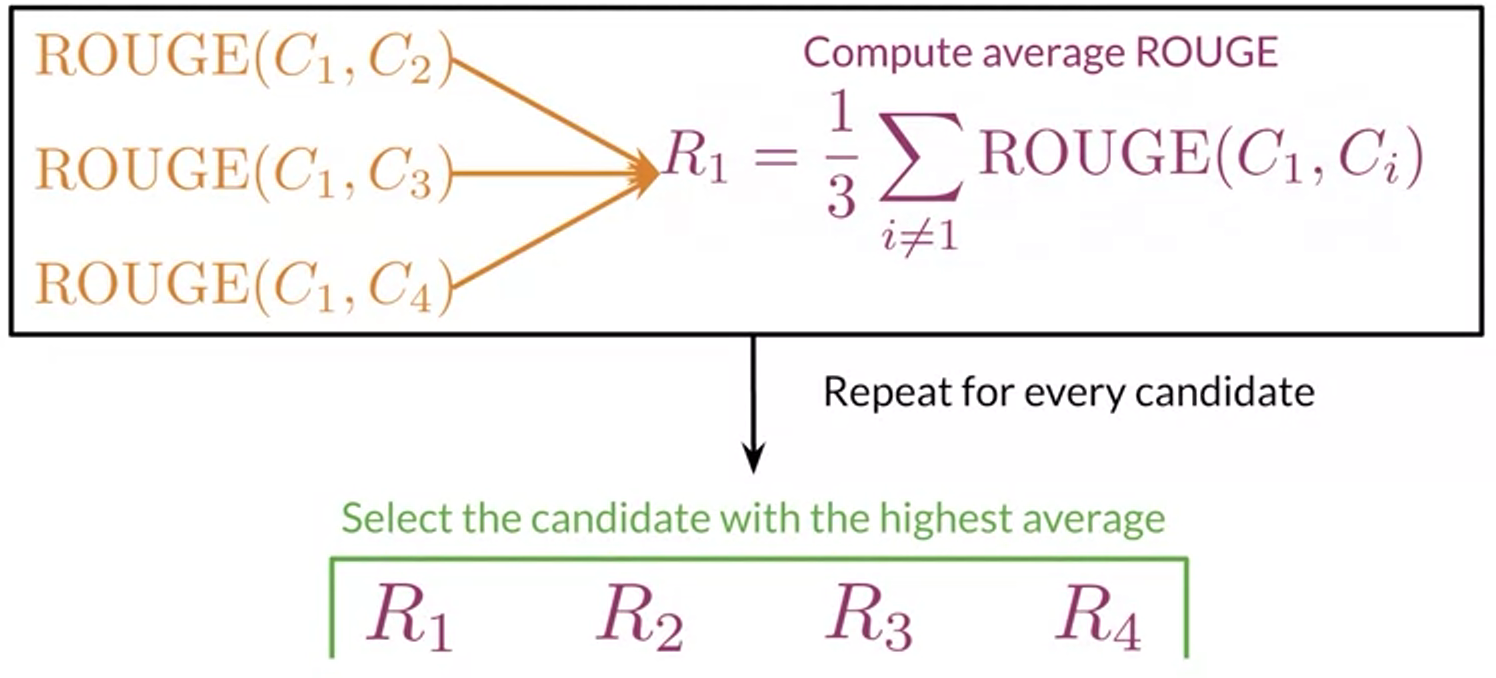

An implementation process in more detail. Here are the steps for implementing MVR with ROUGE on a small set of four candidate translations. 
1. First, calculate the ROUGE score between the first C subscript 1 and the second C subscript 2 candidate translations. 
2. For the 1st and 3rd and for the 1st and 4th, then compute the average R subscript 1 using those three rules scores. 
3. Then you repeat this process for the other three candidates in your sets to average ROUGE scores for each one of them. 
4. Finally, you select the candidate with the highest average ROUGE score and that's it for MBR. 

In summary, MBR:
* takes several translation candidates and compares them against each other
* chooses the one with the highest average similarity as the beam search case
* this method can give you a more contextually accurate translation than random sampling and greedy decoding

# NMT with Attention (implementation)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Setting this env variable prevents TF warnings from showing up

import numpy as np
import tensorflow as tf
from collections import Counter
from utils3 import (sentences, train_data, val_data, english_vectorizer, portuguese_vectorizer, 
                   masked_loss, masked_acc, tokens_to_text)

### Data Preparation
The text pre-processing bits have already been taken care of (if you are interested in this be sure to check the utils.py file). The steps performed can be summarized as:

* Reading the raw data from the text files
* Cleaning the data (using lowercase, adding space around punctuation, trimming whitespaces, etc)
* Splitting it into training and validation sets
* Adding the start-of-sentence and end-of-sentence tokens to every sentence
* Tokenizing the sentences
* Creating a Tensorflow dataset out of the tokenized sentences

In [ ]:
portuguese_sentences, english_sentences = sentences

print(f"English (to translate) sentence:\n\n{english_sentences[-5]}\n")
print(f"Portuguese (translation) sentence:\n\n{portuguese_sentences[-5]}")

# Size of the vocabulary
vocab_size_por = portuguese_vectorizer.vocabulary_size()
vocab_size_eng = english_vectorizer.vocabulary_size()

print(f"Portuguese vocabulary is made up of {vocab_size_por} words")
print(f"English vocabulary is made up of {vocab_size_eng} words")

In [ ]:
# This helps you convert from words to ids
word_to_id = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(), 
    mask_token="", 
    oov_token="[UNK]"
)

# This helps you convert from ids to words
id_to_word = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(),
    mask_token="",
    oov_token="[UNK]",
    invert=True,
)

In [ ]:
unk_id = word_to_id("[UNK]")
sos_id = word_to_id("[SOS]")
eos_id = word_to_id("[EOS]")
baunilha_id = word_to_id("baunilha")

print(f"The id for the [UNK] token is {unk_id}")
print(f"The id for the [SOS] token is {sos_id}")
print(f"The id for the [EOS] token is {eos_id}")
print(f"The id for baunilha (vanilla) is {baunilha_id}")

### Encoder

In [ ]:
VOCAB_SIZE = 12000
UNITS = 256

class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super(Encoder, self).__init__()

        self.embedding = tf.keras.layers.Embedding(  
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )  

        self.rnn = tf.keras.layers.Bidirectional(  
            merge_mode="sum",  
            layer=tf.keras.layers.LSTM(
                units=units,
                return_sequences=True
            ),  
        )  

    def call(self, context):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): The sentence to translate

        Returns:
            tf.Tensor: Encoded sentence to translate
        """

        # Pass the context through the embedding layer
        x = self.embedding(context)

        # Pass the output of the embedding through the RNN
        x = self.rnn(x)

        return x

In [ ]:
# Do a quick check of your implementation

# Create an instance of your class
encoder = Encoder(VOCAB_SIZE, UNITS)

# Pass a batch of sentences to translate from english to portuguese
encoder_output = encoder(to_translate)

print(f'Tensor of sentences in english has shape: {to_translate.shape}\n')
print(f'Encoder output has shape: {encoder_output.shape}')

### CrossAttention

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """Initializes an instance of this class

        Args:
            units (int): Number of units in the LSTM layer
        """
        super().__init__()

        self.mha = ( 
            tf.keras.layers.MultiHeadAttention(
                key_dim=units,
                num_heads=1
            ) 
        )  

        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, context, target):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): Encoded sentence to translate
            target (tf.Tensor): The embedded shifted-to-the-right translation

        Returns:
            tf.Tensor: Cross attention between context and target
        """

        # Call the MH attention by passing in the query and value
        # For this case the query should be the translation and the value the encoded sentence to translate
        # Hint: Check the call arguments of MultiHeadAttention in the docs
        attn_output = self.mha(
            query=target,
            value=context
        )  

        x = self.add([target, attn_output])

        x = self.layernorm(x)

        return x

In [ ]:
# Do a quick check of your implementation

# Create an instance of your class
attention_layer = CrossAttention(UNITS)

# The attention layer expects the embedded sr-translation and the context
# The context (encoder_output) is already embedded so you need to do this for sr_translation:
sr_translation_embed = tf.keras.layers.Embedding(VOCAB_SIZE, output_dim=UNITS, mask_zero=True)(sr_translation)

# Compute the cross attention
attention_result = attention_layer(encoder_output, sr_translation_embed)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of translations has shape: {sr_translation_embed.shape}')
print(f'Tensor of attention scores has shape: {attention_result.shape}')

### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super(Decoder, self).__init__()

        # The embedding layer
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )  

        # The RNN before attention
        self.pre_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True
        )  

        # The attention layer
        self.attention = CrossAttention(units)

        # The RNN after attention
        self.post_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True
        )  

        # The dense layer with logsoftmax activation
        self.output_layer = tf.keras.layers.Dense(
            units=vocab_size,
            activation=tf.nn.log_softmax
        )  

    def call(self, context, target, state=None, return_state=False):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): Encoded sentence to translate
            target (tf.Tensor): The shifted-to-the-right translation
            state (list[tf.Tensor, tf.Tensor], optional): Hidden state of the pre-attention LSTM. Defaults to None.
            return_state (bool, optional): If set to true return the hidden states of the LSTM. Defaults to False.

        Returns:
            tf.Tensor: The log_softmax probabilities of predicting a particular token
        """

        # Get the embedding of the input
        x = self.embedding(target)

        # Pass the embedded input into the pre attention LSTM
        # Hints:
        # - The LSTM you defined earlier should return the output alongside the state (made up of two tensors)
        # - Pass in the state to the LSTM (needed for inference)
        x, hidden_state, cell_state = self.pre_attention_rnn(x, initial_state=state)

        # Perform cross attention between the context and the output of the LSTM (in that order)
        x = self.attention(context, x)

        # Do a pass through the post attention LSTM
        x = self.post_attention_rnn(x)

        # Compute the logits
        logits = self.output_layer(x)

        if return_state:
            return logits, [hidden_state, cell_state]

        return logits

In [ ]:
# Do a quick check of your implementation

# Create an instance of your class
decoder = Decoder(VOCAB_SIZE, UNITS)

# Notice that you don't need the embedded version of sr_translation since this is done inside the class
logits = decoder(encoder_output, sr_translation)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

### Translator

In [ ]:
class Translator(tf.keras.Model):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super().__init__()

        # Define the encoder with the appropriate vocab_size and number of units
        self.encoder = Encoder(vocab_size, units)

        # Define the decoder with the appropriate vocab_size and number of units
        self.decoder = Decoder(vocab_size, units)

    def call(self, inputs):
        """Forward pass of this layer

        Args:
            inputs (tuple(tf.Tensor, tf.Tensor)): Tuple containing the context (sentence to translate) and the target (shifted-to-the-right translation)

        Returns:
            tf.Tensor: The log_softmax probabilities of predicting a particular token
        """

        # In this case inputs is a tuple consisting of the context and the target, unpack it into single variables
        context, target = inputs

        # Pass the context through the encoder
        encoded_context = self.encoder(context)

        # Compute the logits by passing the encoded context and the target to the decoder
        logits = self.decoder(encoded_context, target)

        return logits

In [ ]:
# Do a quick check of your implementation

# Create an instance of your class
translator = Translator(VOCAB_SIZE, UNITS)

# Compute the logits for every word in the vocabulary
logits = translator((to_translate, sr_translation))

print(f'Tensor of sentences to translate has shape: {to_translate.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

### Training

In [ ]:
def compile_and_train(model, epochs=20, steps_per_epoch=500):
    model.compile(optimizer="adam", loss=masked_loss, metrics=[masked_acc, masked_loss])

    history = model.fit(
        train_data.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        validation_steps=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    )

    return model, history

trained_translator, history = compile_and_train(translator)

### Using the model for inference

In [ ]:
def generate_next_token(decoder, context, next_token, done, state, temperature=0.0):
    """Generates the next token in the sequence

    Args:
        decoder (Decoder): The decoder
        context (tf.Tensor): Encoded sentence to translate
        next_token (tf.Tensor): The predicted next token
        done (bool): True if the translation is complete
        state (list[tf.Tensor, tf.Tensor]): Hidden states of the pre-attention LSTM layer
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(tf.Tensor, np.float, list[tf.Tensor, tf.Tensor], bool): The next token, log prob of said token, hidden state of LSTM and if translation is done
    """
    # Get the logits and state from the decoder
    logits, state = decoder(context, next_token, state=state, return_state=True)
    
    # Trim the intermediate dimension 
    logits = logits[:, -1, :]
        
    # If temp is 0 then next_token is the argmax of logits
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
        
    # If temp is not 0 then next_token is sampled out of logits
    else:
        logits = logits / temperature
        next_token = tf.random.categorical(logits, num_samples=1)
    
    # Trim dimensions of size 1
    logits = tf.squeeze(logits)
    next_token = tf.squeeze(next_token)
    
    # Get the logit of the selected next_token
    logit = logits[next_token].numpy()
    
    # Reshape to (1,1) since this is the expected shape for text encoded as TF tensors
    next_token = tf.reshape(next_token, shape=(1,1))
    
    # If next_token is End-of-Sentence token you are done
    if next_token == eos_id:
        done = True
    
    return next_token, logit, state, done

In [ ]:
# PROCESS SENTENCE TO TRANSLATE AND ENCODE

# A sentence you wish to translate
eng_sentence = "I love languages"

# Convert it to a tensor
texts = tf.convert_to_tensor(eng_sentence)[tf.newaxis]

# Vectorize it and pass it through the encoder
context = english_vectorizer(texts).to_tensor()
context = encoder(context)

# SET STATE OF THE DECODER

# Next token is Start-of-Sentence since you are starting fresh
next_token = tf.fill((1,1), sos_id)

# Hidden and Cell states of the LSTM can be mocked using uniform samples
state = [tf.random.uniform((1, UNITS)), tf.random.uniform((1, UNITS))]

# You are not done until next token is EOS token
done = False

# Generate next token
next_token, logit, state, done = generate_next_token(decoder, context, next_token, done, state, temperature=0.5)
print(f"Next token: {next_token}\nLogit: {logit:.4f}\nDone? {done}")

### Translate

Now you can put everything together to translate a given sentence. For this, complete the translate function below. This function will take care of the following steps:

Process the sentence to translate and encode it
Set the initial state of the decoder
Get predictions of the next token (starting with the < SOS > token) for a maximum of iterations (in case the < EOS > token is never returned)
Return the translated text (as a string), the logit of the last iteration (this helps measure how certain was that the sequence was translated in its totality) and the translation in token format.

In [ ]:
def translate(model, text, max_length=50, temperature=0.0):
    """Translate a given sentence from English to Portuguese

    Args:
        model (tf.keras.Model): The trained translator
        text (string): The sentence to translate
        max_length (int, optional): The maximum length of the translation. Defaults to 50.
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(str, np.float, tf.Tensor): The translation, logit that predicted <EOS> token and the tokenized translation
    """
    # Lists to save tokens and logits
    tokens, logits = [], []
    
    # PROCESS THE SENTENCE TO TRANSLATE
    
    # Convert the original string into a tensor
    text = tf.convert_to_tensor(text)[tf.newaxis]
    
    # Vectorize the text using the correct vectorizer
    context = english_vectorizer(text).to_tensor()
    
    # Get the encoded context (pass the context through the encoder)
    # Hint: Remember you can get the encoder by using model.encoder
    context = model.encoder(context)
    
    # INITIAL STATE OF THE DECODER
    
    # First token should be SOS token with shape (1,1)
    next_token = tf.fill((1, 1), sos_id)
    
    # Initial hidden and cell states should be tensors of zeros with shape (1, UNITS)
    state = [tf.zeros((1, UNITS)), tf.zeros((1, UNITS))]
    
    # You are done when you draw a EOS token as next token (initial state is False)
    done = False

    # Iterate for max_length iterations
    for i in range(max_length):
        # Generate the next token
        try:
            next_token, logit, state, done = generate_next_token(
                decoder=model.decoder,
                context=context,
                next_token=next_token,
                done=done,
                state=state,
                temperature=temperature
            )
        except:
             raise Exception("Problem generating the next token")
        
        # If done then break out of the loop
        if done:
            break
        
        # Add next_token to the list of tokens
        tokens.append(next_token)
        
        # Add logit to the list of logits
        logits.append(logit)
        
    # Concatenate all tokens into a tensor
    tokens = tf.concat(tokens, axis=-1)
    
    # Convert the translated tokens into text
    translation = tf.squeeze(tokens_to_text(tokens, id_to_word))
    translation = translation.numpy().decode()
    
    return translation, logits[-1], tokens

In [ ]:
# Try your function with temperature of 0, which will yield a deterministic output and is equivalent to a greedy decoding

temp = 0.0 
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

In [ ]:
# Try your function with temperature of 0.7 (stochastic output)

temp = 0.7
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

### Minimum Bayes-Risk Decoding

As mentioned in the lectures, getting the most probable token at each step may not necessarily produce the best results. Another approach is to do Minimum Bayes Risk Decoding or MBR. The general steps to implement this are:

* Take several random samples
* Score each sample against all other samples
* Select the one with the highest score

In [ ]:
def generate_samples(model, text, n_samples=4, temperature=0.6):
    
    samples, log_probs = [], []

    # Iterate for n_samples iterations
    for _ in range(n_samples):
        
        # Save the logit and the translated tensor
        _, logp, sample = translate(model, text, temperature=temperature)
        
        # Save the translated tensors
        samples.append(np.squeeze(sample.numpy()).tolist())
        
        # Save the logits
        log_probs.append(logp)
                
    return samples, log_probs

In [ ]:
samples, log_probs = generate_samples(trained_translator, 'I love languages')

for s, l in zip(samples, log_probs):
    print(f"Translated tensor: {s} has logit: {l:.3f}")

### Comparing overlaps

Now that you can generate multiple translations it is time to come up with a method to measure the goodness of each one. As you saw in the lectures, one way to achieve this is by comparing each sample against the others.

There are several metrics you can use for this purpose, as shown in the lectures and you can try experimenting with any one of these. For this assignment, you will be calculating scores for unigram overlaps.

One of these metrics is the widely used yet simple Jaccard similarity which gets the intersection over union of two sets. The jaccard_similarity function returns this metric for any pair of candidate and reference translations:

In [ ]:
def jaccard_similarity(candidate, reference):
        
    # Convert the lists to sets to get the unique tokens
    candidate_set = set(candidate)
    reference_set = set(reference)
    
    # Get the set of tokens common to both candidate and reference
    common_tokens = candidate_set.intersection(reference_set)
    
    # Get the set of all tokens found in either candidate or reference
    all_tokens = candidate_set.union(reference_set)
    
    # Compute the percentage of overlap (divide the number of common tokens by the number of all tokens)
    overlap = len(common_tokens) / len(all_tokens)
        
    return overlap

In [ ]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

js = jaccard_similarity(l1, l2)

print(f"jaccard similarity between lists: {l1} and {l2} is {js:.3f}")

### Rouge Similarity

Jaccard similarity is good but a more commonly used metric in machine translation is the ROUGE score. For unigrams, this is called ROUGE-1 and as shown in the lectures, you can output the scores for both precision and recall when comparing two samples. To get the final score, you will want to compute the F1-score

In [ ]:
def rouge1_similarity(candidate, reference):
    """Computes the ROUGE 1 score between two token lists

    Args:
        candidate (list[int]): Tokenized candidate translation
        reference (list[int]): Tokenized reference translation

    Returns:
        float: Overlap between the two token lists
    """

    # Make a frequency table of the candidate and reference tokens
    # Hint: use the Counter class (already imported)
    candidate_word_counts = Counter(candidate)
    reference_word_counts = Counter(reference)
    
    # Initialize overlap at 0
    overlap = 0
    
    # Iterate over the tokens in the candidate frequency table
    # Hint: Counter is a subclass of dict and you can get the keys 
    #       out of a dict using the keys method like this: dict.keys()
    for token in candidate_word_counts.keys():
        
        # Get the count of the current token in the candidate frequency table
        # Hint: You can access the counts of a token as you would access values of a dictionary
        token_count_candidate = candidate_word_counts[token]
        
        # Get the count of the current token in the reference frequency table
        # Hint: You can access the counts of a token as you would access values of a dictionary
        token_count_reference = reference_word_counts[token]
        
        # Update the overlap by getting the minimum between the two token counts above
        overlap += np.min([token_count_candidate, token_count_reference])
    
    # Compute the precision
    # Hint: precision = overlap / (number of tokens in candidate list) 
    precision = overlap / len(candidate)
    
    # Compute the recall
    # Hint: recall = overlap / (number of tokens in reference list) 
    recall = overlap / len(reference)
    
    if precision + recall != 0:
        # Compute the Rouge1 Score
        # Hint: This is equivalent to the F1 score
        f1_score = 2*precision*recall / (precision + recall)
        
        return f1_score
            
    return 0 # If precision + recall = 0 then return 0

In [ ]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

r1s = rouge1_similarity(l1, l2)

print(f"rouge 1 similarity between lists: {l1} and {l2} is {r1s:.3f}")

### Computing the Overall Score

You will now build a function to generate the overall score for a particular sample. As mentioned in the lectures, you need to compare each sample with all other samples. For instance, if we generated 30 sentences, we will need to compare sentence 1 to sentences 2 through 30. Then, we compare sentence 2 to sentences 1 and 3 through 30, and so forth. At each step, we get the average score of all comparisons to get the overall score for a particular sample. To illustrate, these will be the steps to generate the scores of a 4-sample list.

* Get similarity score between sample 1 and sample 2
* Get similarity score between sample 1 and sample 3
* Get similarity score between sample 1 and sample 4
* Get average score of the first 3 steps. This will be the overall score of sample 1
* Iterate and repeat until samples 1 to 4 have overall scores.

The results will be stored in a dictionary for easy lookups.

In [ ]:
def average_overlap(samples, similarity_fn):
    """Computes the arithmetic mean of each candidate sentence in the samples

    Args:
        samples (list[list[int]]): Tokenized version of translated sentences
        similarity_fn (Function): Similarity function used to compute the overlap

    Returns:
        dict[int, float]: A dictionary mapping the index of each translation to its score
    """
    # Initialize dictionary
    scores = {}
    
    # Iterate through all samples (enumerate helps keep track of indexes)
    for index_candidate, candidate in enumerate(samples):    
                        
        # Initially overlap is zero
        overlap = 0
        
        # Iterate through all samples (enumerate helps keep track of indexes)
        for index_sample, sample in enumerate(samples):

            # Skip if the candidate index is the same as the sample index
            if index_sample == index_candidate:
                continue
                
            # Get the overlap between candidate and sample using the similarity function
            sample_overlap = similarity_fn(candidate, sample)
            
            # Add the sample overlap to the total overlap
            overlap += sample_overlap
        
        # Get the score for the candidate by computing the average
        score = overlap / (len(samples) - 1)

        # Only use 3 decimal points
        score = round(score, 3)
        
        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
        
    return scores

In [ ]:
# Test with Jaccard similarity

l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]

avg_ovlp = average_overlap([l1, l2, l3], jaccard_similarity)

print(f"average overlap between lists: {l1}, {l2} and {l3} using Jaccard similarity is:\n\n{avg_ovlp}")

In [ ]:
# Test with Rouge1 similarity

l1 = [1, 2, 3]
l2 = [1, 4]
l3 = [1, 2, 4, 5]
l4 = [5,6]

avg_ovlp = average_overlap([l1, l2, l3, l4], rouge1_similarity)

print(f"average overlap between lists: {l1}, {l2}, {l3} and {l4} using Rouge1 similarity is:\n\n{avg_ovlp}")

In practice, it is also common to see the weighted mean being used to calculate the overall score instead of just the arithmetic mean. This is implemented in the weighted_avg_overlap function below and you can use it in your experiments to see which one will give better results:

In [ ]:
def weighted_avg_overlap(samples, log_probs, similarity_fn):
    
    # Scores dictionary
    scores = {}
    
    # Iterate over the samples
    for index_candidate, candidate in enumerate(samples):    
        
        # Initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0
        
        # Iterate over all samples and log probabilities
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # Skip if the candidate index is the same as the sample index            
            if index_candidate == index_sample:
                continue
                
            # Convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # Update the weighted sum
            weight_sum += sample_p

            # Get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)
            
            # Update the overlap
            overlap += sample_p * sample_overlap
            
        # Compute the score for the candidate
        score = overlap / weight_sum

        # Only use 3 decimal points
        score = round(score, 3)
        
        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
    
    return scores

###  MBR decode

You will now put everything together in the the mbr_decode function below. This final step is not graded as this function is just a wrapper around all the cool stuff you have coded so far!

You can use it to play around, trying different numbers of samples, temperatures and similarity functions!

In [ ]:
def mbr_decode(model, text, n_samples=5, temperature=0.6, similarity_fn=jaccard_similarity):
    
    # Generate samples
    samples, log_probs = generate_samples(model, text, n_samples=n_samples, temperature=temperature)
    
    # Compute the overlap scores
    scores = weighted_avg_overlap(samples, log_probs, similarity_fn)

    # Decode samples
    decoded_translations = [tokens_to_text(s, id_to_word).numpy().decode('utf-8') for s in samples]
    
    # Find the key with the highest score
    max_score_key = max(scores, key=lambda k: scores[k])
    
    # Get the translation 
    translation = decoded_translations[max_score_key]
    
    return translation, decoded_translations

In [ ]:
english_sentence = "I love languages"

translation, candidates = mbr_decode(trained_translator, english_sentence, n_samples=10, temperature=0.6)

print("Translation candidates:")
for c in candidates:
    print(c)

print(f"\nSelected translation: {translation}")

In [ ]:
# TBD